# Data Collection

In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
import timm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from fastai.vision.all import *
from fastdownload import download_url
from PIL import Image

In [5]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [6]:
from duckduckgo_search import ddg_images
from fastcore.all import *
import time

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Searching for 'algae water'


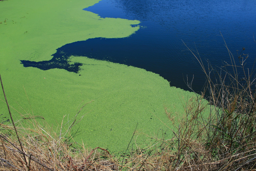

In [10]:
download_url(search_images('algae water')[0], 'algae.jpg', show_progress=True)
Image.open('algae.jpg').to_thumb(256,256)

In [10]:
path = Path('WaterImages')

In [11]:
searches = 'algae water', 'lake water'
path = Path('WaterImageData')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}', max_images=10000))
    print(f'{o} done.')

Searching for 'algae water'
algae water done.
Searching for 'lake water'
lake water done.


In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:3146: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:3146: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:3146: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:3146: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:3146: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/PIL/Image.py:3146: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)
/usr

189

# Model Training

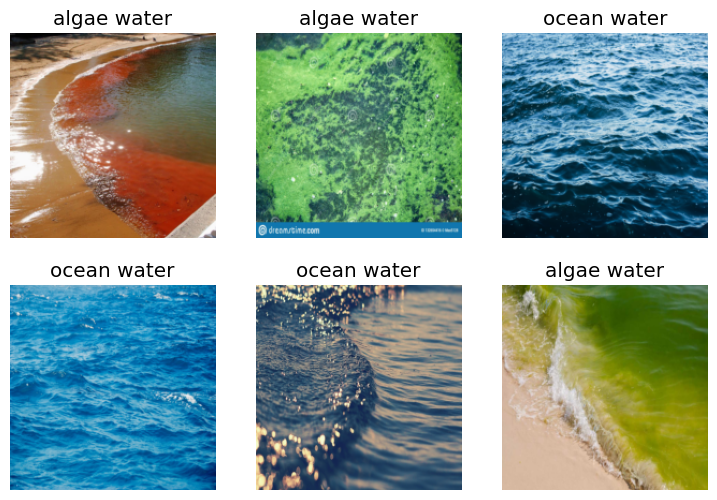

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [21]:
learn = vision_learner(dls, 'convnext_base', metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.640416,0.028883,0.015625,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.048452,0.004991,0.000000,00:10
1,0.033990,0.000711,0.000000,00:10
2,0.027473,0.000594,0.000000,00:09


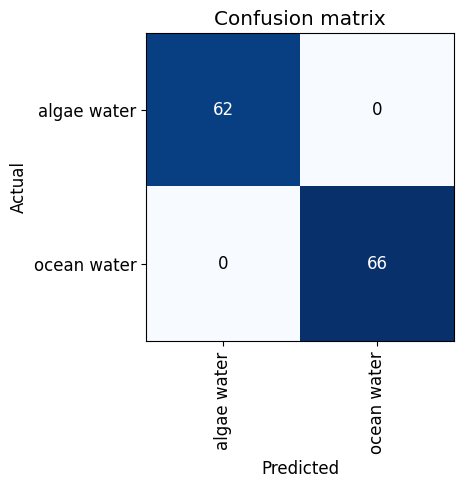

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

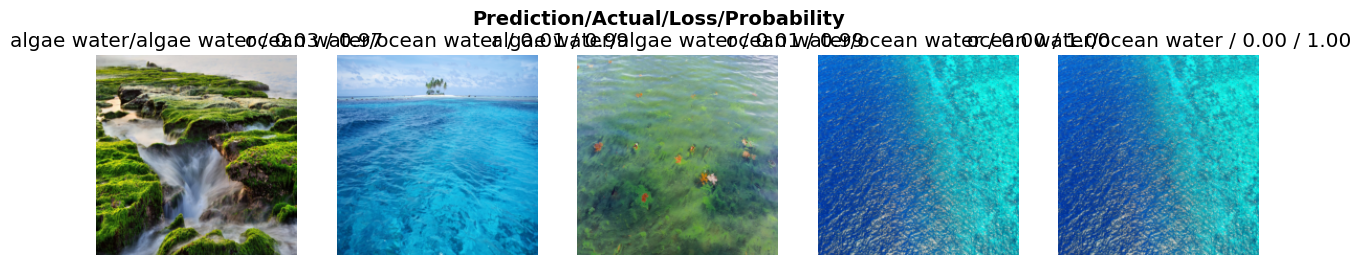

In [23]:
interp.plot_top_losses(5, nrows=1)

In [24]:
learn.path = Path('.')
learn.export()

# Application Deployment

In [28]:
learn = load_learner('export1.pkl')

In [29]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [31]:
import gradio as gr
gr.Interface(fn=predict, inputs=gr.inputs.Image(shape=(512, 512)), outputs=gr.outputs.Label(num_top_classes=3)).launch(share=True)

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://64a78807-d0e4-4023.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/gradio/routes.py", line 337, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.8/dist-packages/gradio/blocks.py", line 1013, in process_api
    inputs = self.preprocess_data(fn_index, inputs, state)
  File "/usr/local/lib/python3.8/dist-packages/gradio/blocks.py", line 911, in preprocess_data
    processed_input.append(block.preprocess(inputs[i]))
  File "/usr/local/lib/python3.8/dist-packages/gradio/components.py", line 1492, in preprocess
    im = processing_utils.decode_base64_to_image(x)
  File "/usr/local/lib/python3.8/dist-packages/gradio/processing_utils.py", line 55, in decode_base64_to_image
    return Image.open(BytesIO(base64.b64decode(image_encoded)))
  File "/usr/local/lib/python3.8/dist-packages/PIL/Image.py", line 3147, in open
    raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f8899